### Imports

In [2]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import ipyleaflet
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns


# Data Science
import numpy as np
import pandas as pd

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score,classification_report,confusion_matrix

# Planetary Computer Tools
import pystac
import pystac_client
import odc
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
from odc.stac import stac_load
import planetary_computer as pc
pc.settings.set_subscription_key('100bbb6552514f27a2e52ef1be8d93b6')  # SJ's primary key

# Others
import requests
import rich.table
from itertools import cycle
from tqdm import tqdm
import xarray as xr
tqdm.pandas()

### EDA

In [3]:
#Read Data
crop_presence_data = pd.read_csv("Crop_Location_Data.csv")
crop_presence_data

Latitude and Longitude Class of Land
0     (10.323727047081501, 105.2516346045924)          Rice
1    (10.322364360592521, 105.27843410554115)          Rice
2    (10.321455902933202, 105.25254306225168)          Rice
3    (10.324181275911162, 105.25118037576274)          Rice
4    (10.324635504740822, 105.27389181724476)          Rice
..                                        ...           ...
595  (10.013942985253381, 105.67361318732796)      Non Rice
596   (10.01348875642372, 105.67361318732796)      Non Rice
597  (10.013034527594062, 105.67361318732796)      Non Rice
598  (10.012580298764401, 105.67361318732796)      Non Rice
599  (10.012126069934741, 105.67361318732796)      Non Rice

[600 rows x 2 columns]

In [ ]:
crop_presence_data[crop_presence_data['Latitude and Longitude'].str.contains('10.324635504740822, 105.25572266405916')]

In [ ]:
crop_presence_data.info()

In [ ]:
# Check for class imbalance
sns.countplot(x=crop_presence_data['Class of Land'])
plt.show()

In [4]:
import ast
crop_presence_data['Latitude and Longitude'] = crop_presence_data['Latitude and Longitude'].apply(ast.literal_eval)

### Download Data

In [5]:
def get_sentinel_data(latlong,time_slice,assets):
    '''
    Returns VV and VH values for a given latitude and longitude 
    Attributes:
    latlong - A tuple with 2 elements - latitude and longitude
    time_slice - Timeframe for which the VV and VH values have to be extracted
    assets - A list of bands to be extracted
    '''

    #latlong=latlong.replace('(','').replace(')','').replace(' ','').split(',')
    box_size_deg = 0.0008 # Surrounding box in degrees, yields approximately 5x5 pixel region
    min_lon = float(latlong[1])-box_size_deg/2
    min_lat = float(latlong[0])-box_size_deg/2
    max_lon = float(latlong[1])+box_size_deg/2
    max_lat = float(latlong[0])+box_size_deg/2

    bbox_of_interest = (min_lon, min_lat, max_lon, max_lat)
    time_of_interest = time_slice

    catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
    
    search = catalog.search(collections=["sentinel-1-rtc"], bbox=bbox_of_interest, datetime=time_of_interest)
    
    items = list(search.get_all_items())
    bands_of_interest = assets
    data = stac_load([items[0]], patch_url=pc.sign, bbox=bbox_of_interest).isel(time=0)
    vh = data["vh"].median().to_numpy()
    vv = data["vv"].median().to_numpy()
    
    return vh,vv

In [7]:
import datetime
from dateutil.relativedelta import relativedelta
from tqdm import tqdm
import pandas as pd

# Define start and end dates
start_date = datetime.date(2022, 11, 1)
end_date = datetime.date(2022, 12, 1)

# Define assets to collect
assets = ['vh', 'vv']

# Define list to store data
data = []

# Iterate over range of dates
while start_date <= end_date:
    next_date = start_date + relativedelta(months=+1)
    time_slice = f'{start_date}/{next_date}'
    for coordinates in tqdm(crop_presence_data['Latitude and Longitude']):
        vv, vh = get_sentinel_data(coordinates, time_slice, assets)
        data.append([time_slice, vv, vh])
    start_date = next_date

# Convert list to DataFrame and save to file
columns = ['date'] + assets
data_vh_vv = pd.DataFrame(data, columns=columns)
data_vh_vv.to_csv('data_2022-11-01_2023-01-01.csv', index=False)

100%|██████████| 600/600 [04:00<00:00,  2.49it/s]


In [21]:
data_vh_vv

date            vh           vv
0    2022-01-01/2022-02-01   0.017495941   0.13887902
1    2022-01-01/2022-02-01   0.028679391   0.07264892
2    2022-01-01/2022-02-01    0.02452453    0.1986736
3    2022-01-01/2022-02-01   0.004701866  0.012505684
4    2022-01-01/2022-02-01   0.015977064  0.023961633
..                     ...           ...          ...
995  2022-04-01/2022-05-01  0.0044893655  0.017656408
996  2022-04-01/2022-05-01   0.004491235   0.02138837
997  2022-04-01/2022-05-01   0.004278449  0.016030608
998  2022-04-01/2022-05-01  0.0071336497  0.027761186
999  2022-04-01/2022-05-01   0.005147928  0.022021143

[1000 rows x 3 columns]

In [24]:
eval_data = pd.read_csv('./Eval/data__val_2022-01-01_2022-3-01.csv')
eval_data2 = pd.read_csv('./Eval/data__val_2022-05-01_2022-9-01.csv')
eval_data3 = pd.read_csv('./Eval/data__val_2022-09-01_2022-12-31.csv')
eval_df = pd.concat([eval_data, eval_data2, eval_data3], axis=0)

In [26]:
eval_df['date'].unique()

array(['2022-01-01/2022-02-01', '2022-02-01/2022-03-01',
       '2022-03-01/2022-04-01', '2022-04-01/2022-05-01',
       '2022-05-01/2022-06-01', '2022-06-01/2022-07-01',
       '2022-07-01/2022-08-01', '2022-08-01/2022-09-01',
       '2022-09-01/2022-10-01', '2022-10-01/2022-11-01',
       '2022-11-01/2022-12-01', '2022-12-01/2023-01-01'], dtype=object)

In [15]:
data_1 = pd.read_csv('data_2022-01-01_2022-05-01.csv')
data_2 = pd.read_csv('data_2022-04-01_2022-07-01.csv')
data_3 = pd.read_csv('data_2022-07-01_2022-11-01.csv')
data_4 = pd.read_csv('data_2022-11-01_2023-01-01.csv')

In [16]:
data_df = pd.concat([data_1, data_2, data_3, data_4], axis=0)
data_df.shape

(7200, 3)

In [177]:
data_df

date        vh        vv
0     2022-01-01/2022-02-01  0.027253  0.141300
1     2022-01-01/2022-02-01  0.019327  0.398268
2     2022-01-01/2022-02-01  0.033112  0.143685
3     2022-01-01/2022-02-01  0.033152  0.121286
4     2022-01-01/2022-02-01  0.022331  0.205135
...                     ...       ...       ...
1195  2022-12-01/2023-01-01  0.056471  0.160070
1196  2022-12-01/2023-01-01  0.054658  0.167050
1197  2022-12-01/2023-01-01  0.055214  0.236458
1198  2022-12-01/2023-01-01  0.048543  0.255147
1199  2022-12-01/2023-01-01  0.042360  0.287241

[7200 rows x 3 columns]

In [181]:
data_df.head()

date        vh        vv
0  2022-01-01/2022-02-01  0.027253  0.141300
1  2022-01-01/2022-02-01  0.019327  0.398268
2  2022-01-01/2022-02-01  0.033112  0.143685
3  2022-01-01/2022-02-01  0.033152  0.121286
4  2022-01-01/2022-02-01  0.022331  0.205135

### Process Data

RVI(v) = (4*VH)/(VV+VH)

In [27]:
# def calculate_rvi(vh, vv) -> float:
#     dop = (vv / (vv + vh))
#     m = 1 - dop
#     return (np.sqrt(dop))*((4*vh)/(vv + vh))
# # TypeError: loop of ufunc does not support argument 0 of type numpy.float64 which has no callable sqrt method

### Pipe

#### Funcs

In [218]:
from sklearn.compose import ColumnTransformer
import xarray as xr

def calculate_rvi(df):
    df = df.assign(rvi = lambda x: ((4*x.vh)/(x.vv+x.vh)))
    return df

def _calc_ma(x, period) -> float:
    return x.rolling(window=period).mean()

def calculate_ma(df, period):
    df = df.assign(rvi_ma = lambda x: _calc_ma(x.rvi, period)) # Calculate moving average with a window of 7 days
    return df


def assign_index(df):

    new_index = [i % int(len(df)/12) for i in range(len(df))]
    df2 = df
    
    # Assign the new index values to the DataFrame
    df2['field'] = new_index

    
    
    return df2




def merge_dfs(df, crop):
    
    if 'target' in crop.columns:
        crop.target= 0
        crop.columns = ['Latitude and Longitude', 'Class of Land']
    
    crop = crop.reset_index()
    df = df.merge(crop, left_on='field', right_on=crop['index'])
    
    df = df.drop('Latitude and Longitude', axis=1)
    df = df.drop('Class of Land', axis=1)
    


    return df


def xr_transform(df):
    df = df.drop('index', axis=1)
    ds = df.set_index(['field', 'date']).to_xarray()
    ds.set_coords('date')
    
    df_full = ds.to_dataframe()
    return df_full

#### Col Transformer


In [219]:
from sklearn.base import BaseEstimator, TransformerMixin

class CustomColumnTransformer(BaseEstimator, TransformerMixin):
    def __init__(self,crop_info_path='Crop_Location_Data_or.csv' ,ma_window=7):
        self.crop_info_path=crop_info_path
        self.ma_window = ma_window
    
    def fit(self, X, crop_info_path='Crop_Location_Data.csv', y=None):
        return self
    
    def transform(self, X):
        # Step 1: Calculate RVI
        X = calculate_rvi(X)
        
        # Step 2: Calculate moving average with a window of ma_window days
        X = calculate_ma(X, self.ma_window)
        
        # Step 3: Assign new index values to the DataFrame
        X = assign_index(X)
        
        
        # Step 4: Merge the input DataFrame with the crop information
        crop = pd.read_csv(self.crop_info_path)
        
        X = merge_dfs(X, crop)
    
        # Step 5: Transform the DataFrame to xarray format and drop the 'target' dimension
        X = xr_transform(X)
        
        # Return the transformed DataFrame
        return X

#### Clustering


In [178]:
import matplotlib.pyplot as plt
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import KShape
from tslearn.metrics import cdist_dtw
from sklearn.metrics import silhouette_score

class TimeSeriesClusteringTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, n_clusters=7, window_size=2):
        self.n_clusters = n_clusters
        self.window_size = window_size
        self.scaler = None
        self.kshape = None
        
    def fit(self, X, y=None):
        # Assuming your data is in a pandas Series called 'data'
        data = pd.Series(X['rvi_ma'].fillna(0))

        # Create a DataFrame from your data
        df = data.reset_index()

        # Pivot the DataFrame to create a 2D array where each row represents a time series
        pivot_df = df.pivot_table(values='rvi_ma', index='field', columns='date')

        # Convert the pivoted DataFrame to a 2D numpy array
        time_series_data = pivot_df.to_numpy()

        ## Apply Moving Average (MA)
        # Apply Simple Moving Average (SMA) with a window size of your choice
        window_size = self.window_size
        time_series_data_sma = pivot_df.rolling(window=window_size, axis=1).mean()

        # Drop any rows with NaN values due to the rolling window operation
        time_series_data_sma.dropna(axis=1, inplace=True)

        # Convert the pivoted DataFrame with SMA to a 2D numpy array
        time_series_data = time_series_data_sma.to_numpy()

        ## Scale time series
        self.scaler = TimeSeriesScalerMeanVariance(mu=0.0, std=1.0)
        self.scaler.fit(time_series_data)

        ## Perform time series clustering using k-Shape
        n_clusters = self.n_clusters
        self.kshape = KShape(n_clusters=n_clusters, n_init=10, verbose=False, random_state=42)
        self.kshape.fit(self.scaler.transform(time_series_data))

        return self
    
    def transform(self, X, y=None):
        
        # Assuming your data is in a pandas Series called 'data'
        data = pd.Series(X['rvi_ma'].fillna(0))

        # Create a DataFrame from your data
        df = data.reset_index()

        # Pivot the DataFrame to create a 2D array where each row represents a time series
        pivot_df = df.pivot_table(values='rvi_ma', index='field', columns='date')

        # Convert the pivoted DataFrame to a 2D numpy array
        time_series_data = pivot_df.to_numpy()

        ## Apply Moving Average (MA)
        # Apply Simple Moving Average (SMA) with a window size of your choice
        window_size = self.window_size
        time_series_data_sma = pivot_df.rolling(window=window_size, axis=1).mean()

        # Drop any rows with NaN values due to the rolling window operation
        time_series_data_sma.dropna(axis=1, inplace=True)

        # Convert the pivoted DataFrame with SMA to a 2D numpy array
        time_series_data = time_series_data_sma.to_numpy()

        ## Scale time series
        time_series_data_scaled = self.scaler.transform(time_series_data)

        ## Perform time series clustering using k-Shape
        y_pred = self.kshape.predict(time_series_data_scaled)

        # Calculate the distance matrix using Dynamic Time Warping (DTW)
        distance_matrix = cdist_dtw(time_series_data_scaled)

        # Calculate the silhouette score
        silhouette = silhouette_score(distance_matrix, y_pred, metric='precomputed')
        
        # Return the transformed data and silhouette score as a tuple
        return time_series_data_scaled, y_pred, silhouette, pivot_df, time_series_data


## Run Pipe

#### Loop Through Cluster/Window Combinations


In [236]:
# Create a column transformer with the custom transformer as a step


from sklearn.pipeline import Pipeline

for w in np.arange(1,6):

    for n in np.arange(2,10):
        custom_col_transformer = Pipeline([
            ('custom', CustomColumnTransformer(ma_window=7)),
            ('timeseries',TimeSeriesClusteringTransformer(n_clusters=n, window_size=w))
        ])


        time_series_data_scaled, y_pred, silhouette, pivot_df, time_series_data = custom_col_transformer.fit_transform(data_df)
        print(f'Silhouette score for {n} clusters while {w} window: {silhouette}')



Silhouette score for 2 clusters while 1 window: 0.18295929317262366
Silhouette score for 3 clusters while 1 window: 0.2572377088101147
Silhouette score for 4 clusters while 1 window: 0.3345988221149069
Silhouette score for 5 clusters while 1 window: 0.30419237051835707
Silhouette score for 6 clusters while 1 window: 0.25034691301349765
Silhouette score for 7 clusters while 1 window: 0.3251146600015716
Silhouette score for 8 clusters while 1 window: 0.2926957832710938
Silhouette score for 9 clusters while 1 window: 0.3613372939268458
Silhouette score for 2 clusters while 2 window: 0.22893223396985102
Silhouette score for 3 clusters while 2 window: 0.2348084804793439
Silhouette score for 4 clusters while 2 window: 0.33780527619703754
Silhouette score for 5 clusters while 2 window: 0.2959036080325608
Silhouette score for 6 clusters while 2 window: 0.2960103625268942
Silhouette score for 7 clusters while 2 window: 0.3109292916886873
Silhouette score for 8 clusters while 2 window: 0.2741156

In [19]:
data_val = pd.concat([
    pd.read_csv('./Eval/data__val_2022-01-01_2022-3-01.csv'),
    pd.read_csv('./Eval/data__val_2022-05-01_2022-9-01.csv'),
    pd.read_csv('./Eval/data__val_2022-09-01_2022-12-31.csv')], axis=0)

In [220]:
# Train Col Transformer

custom_col_transformer_train = Pipeline([
    ('custom', CustomColumnTransformer(ma_window=7, crop_info_path='Crop_Location_Data_or.csv'))
])
df_train = custom_col_transformer_train.transform(data_df)


In [221]:
df_train

vh        vv       rvi    rvi_ma
field date                                                         
0     2022-01-01/2022-02-01  0.027253  0.141300  0.646754       NaN
      2022-02-01/2022-03-01  0.037834  0.129970  0.901852  0.841573
      2022-03-01/2022-04-01  0.031183  0.080205  1.119797  0.807760
      2022-04-01/2022-05-01  0.007492  0.181525  0.158537  0.696798
      2022-05-01/2022-06-01  0.027550  0.106956  0.819285  0.883964
...                               ...       ...       ...       ...
599   2022-08-01/2022-09-01  0.069576  0.321505  0.711630  0.759540
      2022-09-01/2022-10-01  0.074503  0.270120  0.864753  0.803444
      2022-10-01/2022-11-01  0.063617  0.293964  0.711634  0.801254
      2022-11-01/2022-12-01  0.050067  0.246761  0.674693  0.732237
      2022-12-01/2023-01-01  0.042360  0.287241  0.514076  0.796429

[7200 rows x 4 columns]

In [222]:
# Eval Col Transformer

custom_col_transformer_eval = Pipeline([
    ('custom', CustomColumnTransformer(ma_window=7, crop_info_path='Crop_Location_Data.csv'))
])
df_eval = custom_col_transformer_eval.transform(data_val)


In [223]:
# Fit Clustering
custom_transformer=Pipeline([
    ('timeseries',TimeSeriesClusteringTransformer(n_clusters=9, window_size=1))])

time_series_data_scaled, y_pred, silhouette, pivot_df, time_series_data = custom_transformer.fit_transform(df_train)



In [226]:
# Eval Clustering
time_series_data_scaled, y_pred, silhouette, pivot_df, time_series_data = custom_transformer.transform(df_eval)

In [204]:
df_eval

vh        vv       rvi    rvi_ma
field date                  target                                        
0     2022-01-01/2022-02-01 0       0.017496  0.138879  0.447538       NaN
      2022-02-01/2022-03-01 0       0.021457  0.077430  0.867933  0.973352
      2022-03-01/2022-04-01 0       0.049652  0.107100  1.267032  1.037454
      2022-04-01/2022-05-01 0       0.010012  0.211631  0.180687  0.718521
      2022-05-01/2022-06-01 0       0.018746  0.171211  0.394747  0.713552
...                                      ...       ...       ...       ...
249   2022-08-01/2022-09-01 0       0.006859  0.026705  0.817436  0.877499
      2022-09-01/2022-10-01 0       0.007096  0.104388  0.254615  0.718667
      2022-10-01/2022-11-01 0       0.017523  0.224434  0.289688  0.911711
      2022-11-01/2022-12-01 0       0.035081  0.095839  1.071840  0.934069
      2022-12-01/2023-01-01 0       0.039315  0.201676  0.652554  0.960062

[3000 rows x 4 columns]

In [227]:
# Create a DataFrame to store the time series data and the cluster labels
result_df = pivot_df.copy()
result_df['Cluster'] = y_pred

# Calculate statistical information for each cluster and add to the result DataFrame
for cluster in range(9):
    cluster_data = time_series_data[y_pred == cluster]

    # Calculate mean and variance
    cluster_mean = np.mean(cluster_data, axis=0)
    cluster_variance = np.var(cluster_data, axis=0)

    # Calculate autocorrelation
    cluster_data_df = pd.DataFrame(cluster_data)
    cluster_autocorr = cluster_data_df.apply(lambda x: x.autocorr(), axis=1).mean()

    # Add statistical information to the result DataFrame
    result_df.loc[result_df['Cluster'] == cluster, 'Mean'] = cluster_mean.mean()
    result_df.loc[result_df['Cluster'] == cluster, 'Variance'] = cluster_variance.mean()
    result_df.loc[result_df['Cluster'] == cluster, 'Autocorrelation'] = cluster_autocorr

# Print the result
result_df.head(50)

date   2022-01-01/2022-02-01  2022-02-01/2022-03-01  2022-03-01/2022-04-01  \
field                                                                        
0                   0.000000               0.973352               1.037454   
1                   0.000000               0.949083               1.040288   
2                   0.000000               0.883972               1.061897   
3                   0.000000               0.879501               1.017547   
4                   0.000000               0.821034               0.965313   
5                   0.000000               0.819761               0.953183   
6                   0.931281               0.871058               0.899105   
7                   1.003056               0.895563               0.883022   
8                   1.023495               0.893867               0.864941   
9                   1.038702               0.933724               0.895909   
10                  0.940911               0.888960               0.877726   
11                  0.737750               0.946665               0.956524   
12                  0.640117               0.963461               1.092964   
13                  0.619067               0.977318               1.078173   
14                  0.623615               0.949038               1.037446   
15                  0.626596               0.961102               1.061701   
16                  0.681518               0.959457               1.083041   
17                  0.735428               1.000491               1.168868   
18                  0.824801               0.920324               1.074331   
19                  0.958407               0.880002               0.908208   
20                  1.020727               0.882296               0.936046   
21                  0.934991               0.876113               0.910435   
22                  0.907388               0.878025               0.962992   
23                  0.902660               0.854109               0.861922   
24                  0.955049               0.819461               0.820108   
25                  0.925587               0.858623               0.917591   
26                  0.851205               0.886009               0.933433   
27                  0.763027               0.881142               0.887882   
28                  0.850834               0.886006               0.888793   
29                  0.918488               0.864453               0.786389   
30                  0.920324               0.887028               0.828757   
31                  0.788854               1.002150               0.925636   
32                  0.899871               1.015219               0.785047   
33                  0.892932               1.021351               0.856366   
34                  0.957378               1.042349               0.829170   
35                  0.933448               1.038492               0.840646   
36                  0.797452               1.002937               0.830143   
37                  0.843857               1.020876               0.810720   
38                  0.887927               0.904293               0.734986   
39                  0.773530               0.902365               0.839349   
40                  0.909321               0.918158               0.747485   
41                  0.895821               0.924246               0.820322   
42                  0.839009               0.946457               0.830287   
43                  0.829539               0.992454               0.919963   
44                  0.677994               1.055670               0.999720   
45                  0.735034               1.081052               0.959552   
46                  0.752836               1.067935               0.899683   
47                  0.675067               1.000095               1.016322   
48                  0.722411               1.014634               0.952630   
49                  0.

In [161]:
result_df.Cluster.unique()

array([6, 4, 0, 5, 1, 3, 7, 8, 2], dtype=int64)

In [228]:
# Save to disk
result_df.to_csv('time_series_clustering_9c_1w_eval.csv', index=False)

In [229]:
result_df.Cluster.unique()

array([6, 4, 0, 5, 1, 3, 7, 8, 2], dtype=int64)

# OG Code

In [331]:
pd.read_csv('Crop_Location_Data.csv')

Latitude and Longitude Class of Land
0     (10.323727047081501, 105.2516346045924)          Rice
1    (10.322364360592521, 105.27843410554115)          Rice
2    (10.321455902933202, 105.25254306225168)          Rice
3    (10.324181275911162, 105.25118037576274)          Rice
4    (10.324635504740822, 105.27389181724476)          Rice
..                                        ...           ...
595  (10.013942985253381, 105.67361318732796)      Non Rice
596   (10.01348875642372, 105.67361318732796)      Non Rice
597  (10.013034527594062, 105.67361318732796)      Non Rice
598  (10.012580298764401, 105.67361318732796)      Non Rice
599  (10.012126069934741, 105.67361318732796)      Non Rice

[600 rows x 2 columns]

In [34]:
eval_df = eval_df.assign(rvi = lambda x: ((4*x.vh)/(x.vv+x.vh)))

In [123]:
data_df = data_df.assign(rvi = lambda x: ((4*x.vh)/(x.vv+x.vh)))


In [98]:
# Calculate moving average with a window of 7 days
def _calculate_ma(x, period) -> float:
    return x.rolling(window=period).mean()

In [37]:
eval_df = eval_df.assign(rvi_ma = lambda x: _calculate_ma(x.rvi, 7))

In [130]:
data_df = data_df.assign(rvi_ma = lambda x: calculate_ma(x.rvi, 7))

AttributeError: 'Series' object has no attribute 'assign'

In [41]:
eval_df2 = eval_df.copy()

new_index = [i % 250 for i in range(len(eval_df2))]

# Assign the new index values to the DataFrame
eval_df2['field'] = new_index
eval_df2 = eval_df2.set_index(['field', 'date'])

In [152]:
data_df2 = data_df

new_index = [i % 600 for i in range(len(data_df2))]

# Assign the new index values to the DataFrame
data_df2['field'] = new_index
data_df2 = data_df2.set_index(['field', 'date'])

In [132]:
crop_field = pd.read_csv('Crop_Location_Data.csv')
crop_field.shape

(600, 2)

In [218]:
crop_field.head()

Latitude and Longitude Class of Land
0   (10.323727047081501, 105.2516346045924)          Rice
1  (10.322364360592521, 105.27843410554115)          Rice
2  (10.321455902933202, 105.25254306225168)          Rice
3  (10.324181275911162, 105.25118037576274)          Rice
4  (10.324635504740822, 105.27389181724476)          Rice

In [18]:
#  crop field info for train data
crop_field = pd.read_csv('Crop_Location_Data_or.csv')

In [57]:

eval_df2 = eval_df2.fillna(method='bfill')

In [17]:
# Crop Data for Eval

crop_presence_data = pd.read_csv('Crop_Location_Data.csv')

KeyError: "['target'] not found in axis"

In [133]:
crop_presence_data = crop_presence_data.reset_index()

In [69]:
crop_presence_data

index                                        id
0        0   (10.18019073690894, 105.32022315786804)
1        1  (10.561107033461816, 105.12772097986661)
2        2  (10.623790611954897, 105.13771401411867)
3        3  (10.583364246115156, 105.23946127195805)
4        4   (10.20744446668854, 105.26844107128906)
..     ...                                       ...
245    245  (10.308283266873062, 105.50872812216863)
246    246  (10.582910017285496, 105.23991550078767)
247    247  (10.581547330796518, 105.23991550078767)
248    248  (10.629241357910818, 105.15315779432643)
249    249  (10.574733898351617, 105.10410108072531)

[250 rows x 2 columns]

In [70]:
evdf = eval_df2.merge(crop_presence_data, left_on='field', right_on='index')
evdf.shape

(3000, 6)

In [155]:
df = data_df.merge(crop_field, left_on='field', right_on=crop_field.index)
df.shape

(7200, 7)

In [135]:
df = df.drop('Latitude and Longitude', axis=1)
df.shape

(7200, 6)

In [136]:
df = df.rename({'Class of Land':'target'}, axis=1)
df.head()

date        vh        vv       rvi  field target
0  2022-01-01/2022-02-01  0.027253  0.141300  0.646754      0   Rice
1  2022-02-01/2022-03-01  0.037834  0.129970  0.901852      0   Rice
2  2022-03-01/2022-04-01  0.031183  0.080205  1.119797      0   Rice
3  2022-04-01/2022-05-01  0.007492  0.181525  0.158537      0   Rice
4  2022-05-01/2022-06-01  0.027550  0.106956  0.819285      0   Rice

In [137]:
import xarray as xr

ds = df.set_index(['field', 'date', 'target']).to_xarray()
ds.set_coords('date')

<xarray.Dataset>
Dimensions:  (field: 600, date: 12, target: 2)
Coordinates:
  * field    (field) int64 0 1 2 3 4 5 6 7 8 ... 592 593 594 595 596 597 598 599
  * date     (date) object '2022-01-01/2022-02-01' ... '2022-12-01/2023-01-01'
  * target   (target) object 'Non Rice' 'Rice'
Data variables:
    vh       (field, date, target) float64 nan 0.02725 nan ... nan 0.04236 nan
    vv       (field, date, target) float64 nan 0.1413 nan ... nan 0.2872 nan
    rvi      (field, date, target) float64 nan 0.6468 nan ... nan 0.5141 nan

In [264]:
# Save to disk
# ds.to_netcdf('data.nc')

In [101]:
# Load from disk
import xarray as xr

ds = xr.open_dataset("data.nc")
ds

<xarray.Dataset>
Dimensions:      (field_index: 600, date: 12, target: 2)
Coordinates:
  * field_index  (field_index) int64 0 1 2 3 4 5 6 ... 594 595 596 597 598 599
  * date         (date) object '2022-01-01/2022-02-01' ... '2022-12-01/2023-0...
  * target       (target) object 'Non Rice' 'Rice'
Data variables:
    vh           (field_index, date, target) float64 ...
    vv           (field_index, date, target) float64 ...
    rvi          (field_index, date, target) float64 ...
    rvi_ma       (field_index, date, target) float64 ...

In [102]:
ds.drop('target')

<xarray.Dataset>
Dimensions:      (field_index: 600, date: 12, target: 2)
Coordinates:
  * field_index  (field_index) int64 0 1 2 3 4 5 6 ... 594 595 596 597 598 599
  * date         (date) object '2022-01-01/2022-02-01' ... '2022-12-01/2023-0...
Dimensions without coordinates: target
Data variables:
    vh           (field_index, date, target) float64 ...
    vv           (field_index, date, target) float64 ...
    rvi          (field_index, date, target) float64 ...
    rvi_ma       (field_index, date, target) float64 ...

In [103]:
df_full = ds.to_dataframe()
df_full.shape

(14400, 4)

### Plot Timeseries

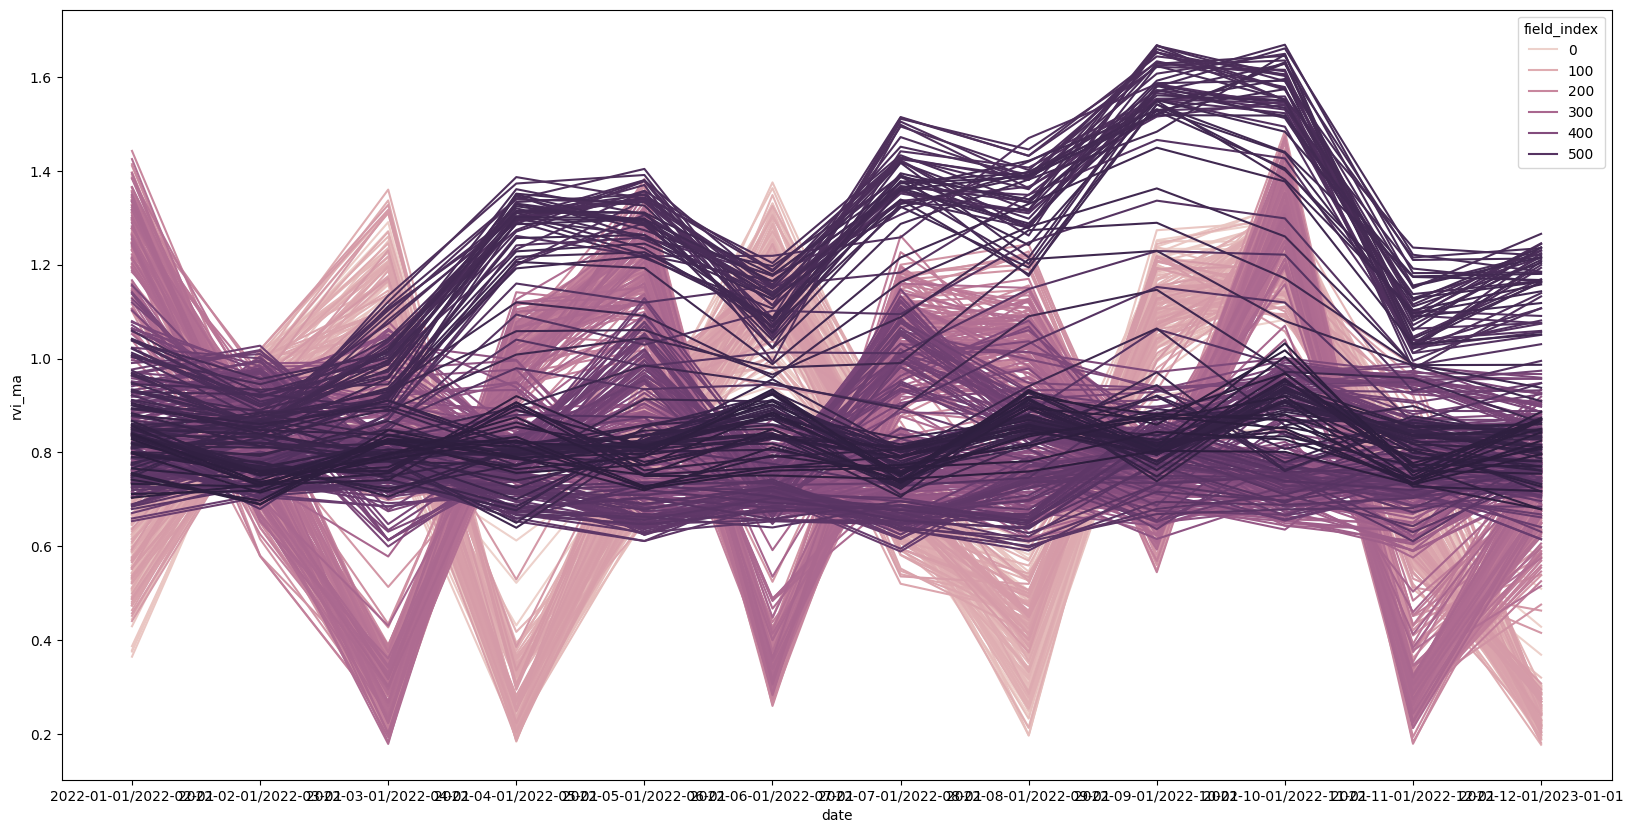

In [73]:
# setting the dimensions of the plot
fig, ax = plt.subplots(figsize=(20, 10))

sns.lineplot(data=df_full, x="date", y="rvi_ma", hue="field_index")

fig.savefig("data.png") 

In [75]:
df_rice = ds.sel(target='Rice').to_dataframe()
df_rice.shape

(7200, 5)

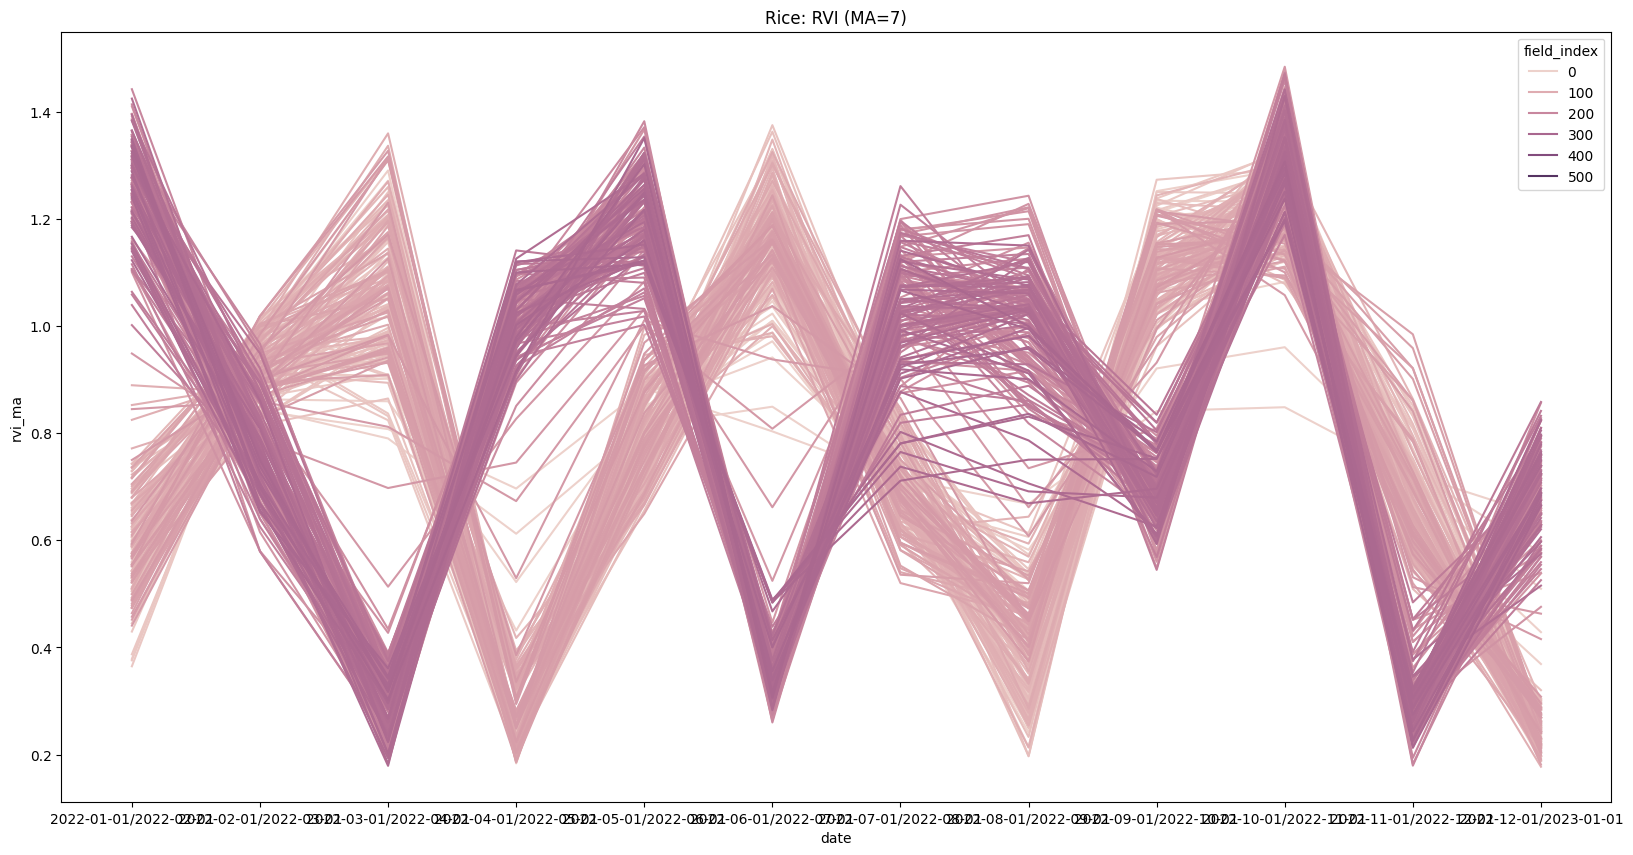

In [76]:
# setting the dimensions of the plot
fig, ax = plt.subplots(figsize=(20, 10))

sns.lineplot(data=df_rice, x="date", y="rvi_ma", hue="field_index").set(title='Rice: RVI (MA=7)')

fig.savefig("data_rice.png") 

In [77]:
df_non_rice = ds.sel(target='Non Rice').to_dataframe()
df_non_rice.shape

(7200, 5)

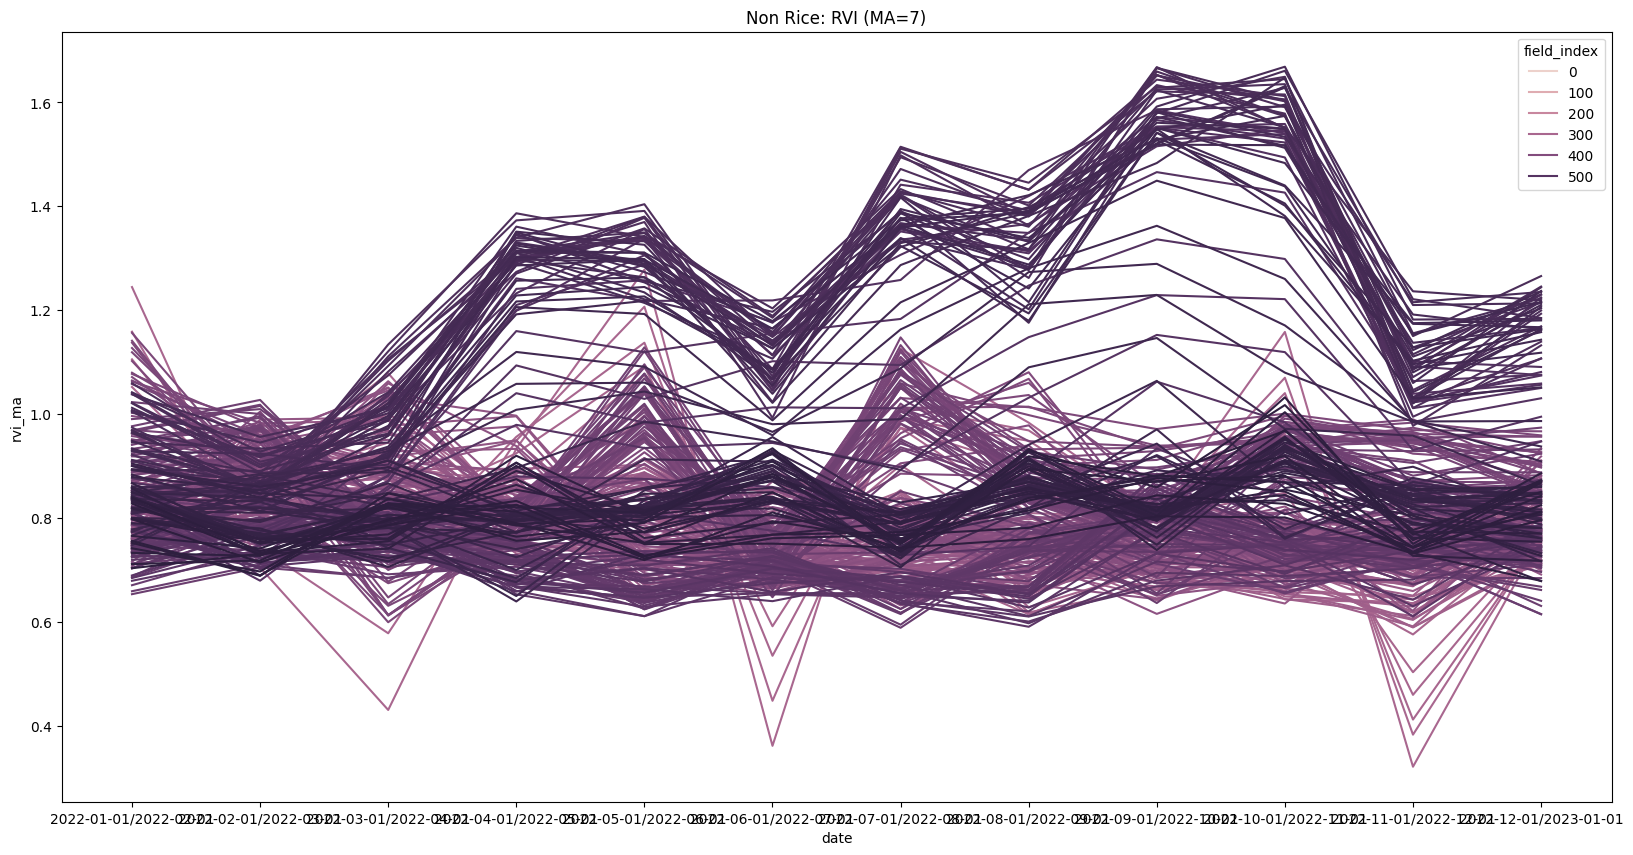

In [78]:
# setting the dimensions of the plot
fig, ax = plt.subplots(figsize=(20, 10))

sns.lineplot(data=df_non_rice, x="date", y="rvi_ma", hue="field_index").set(title='Non Rice: RVI (MA=7)')

fig.savefig("data_non_rice.png") 

## Prepare data

In [67]:
data = df_full.copy()

In [68]:
# Assuming your data is in a pandas Series called 'data'
data = pd.Series(data_df2['rvi_ma'].fillna(0))

# Create a DataFrame from your data
df = data.reset_index()

# Pivot the DataFrame to create a 2D array where each row represents a time series
pivot_df = df.pivot_table(values='rvi_ma', index='field', columns='date')

# Convert the pivoted DataFrame to a 2D numpy array
time_series_data = pivot_df.to_numpy()

## Apply Fast Fourier Transform (FFT)

In [69]:
# Apply FFT to the time series data
time_series_data_fft = np.fft.fft(time_series_data)

# Convert complex numbers to magnitude (absolute value)
time_series_data_magnitude = np.abs(time_series_data_fft)

## Apply Moving Average (MA)

In [80]:
# Apply Simple Moving Average (SMA) with a window size of your choice
window_size = 2
time_series_data_sma = pivot_df.rolling(window=window_size, axis=1).mean()

# Drop any rows with NaN values due to the rolling window operation
time_series_data_sma.dropna(axis=1, inplace=True)

# Convert the pivoted DataFrame with SMA to a 2D numpy array
time_series_data = time_series_data_sma.to_numpy()

## Perform the Clustering

Init 1
0.068 --> 0.058 --> 0.058 --> 0.076 --> 
Init 2
0.037 --> 0.041 --> 
Init 3
0.026 --> 0.041 --> 
Init 4
0.029 --> 0.043 --> 
Init 5
0.045 --> 0.052 --> 
Init 6
0.052 --> 0.057 --> 
Init 7
0.029 --> 0.038 --> 
Init 8
0.031 --> 0.051 --> 
Init 9
0.043 --> 0.037 --> 0.053 --> 
Init 10
0.044 --> 0.051 --> 


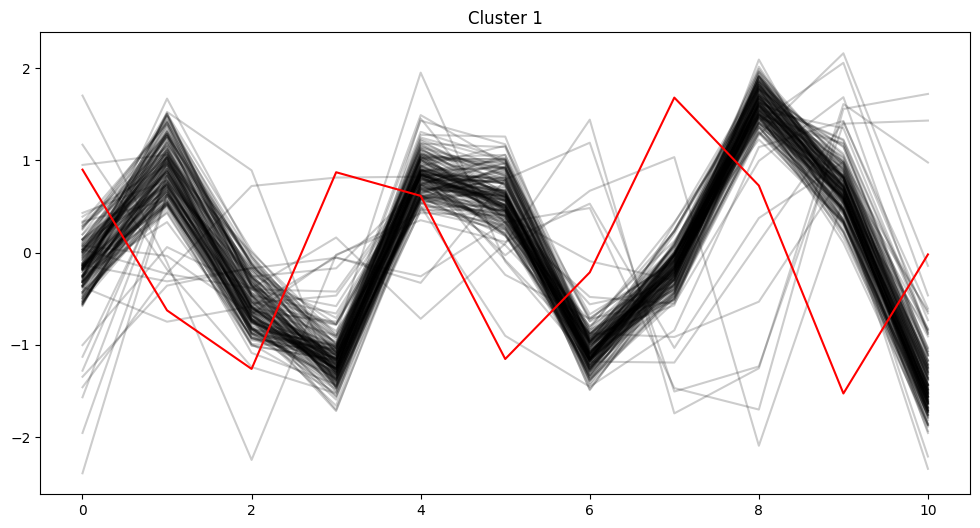

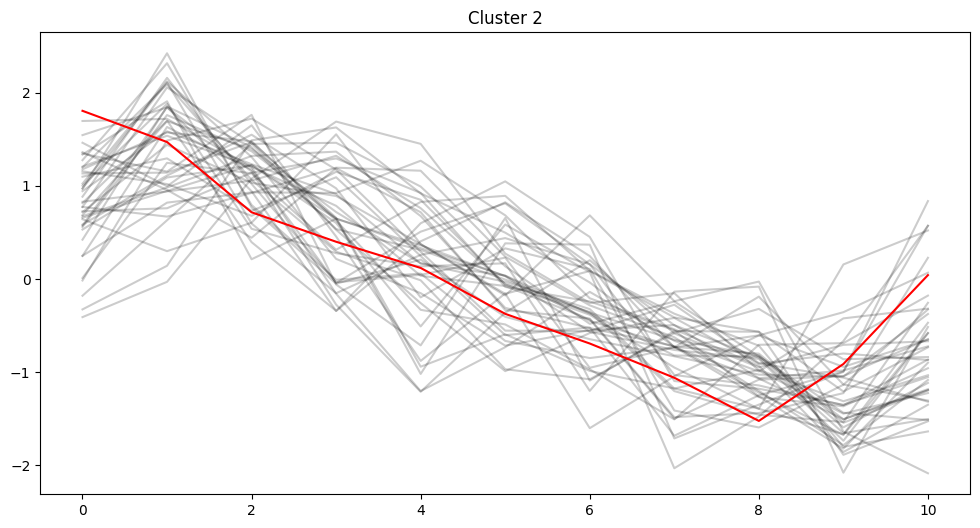

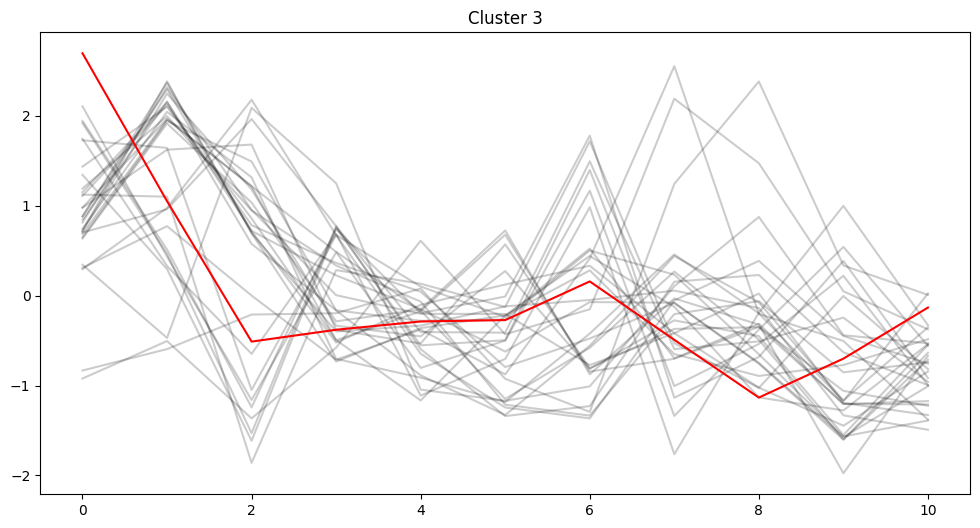

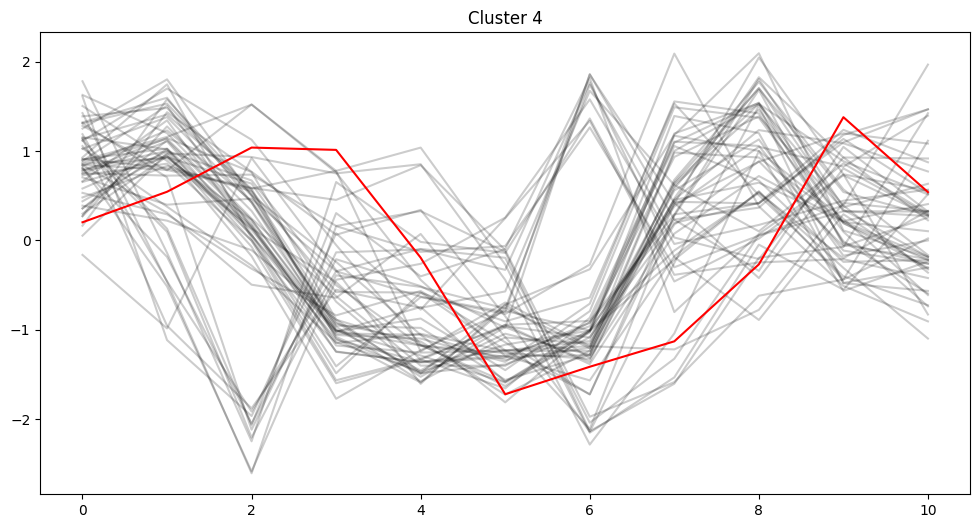

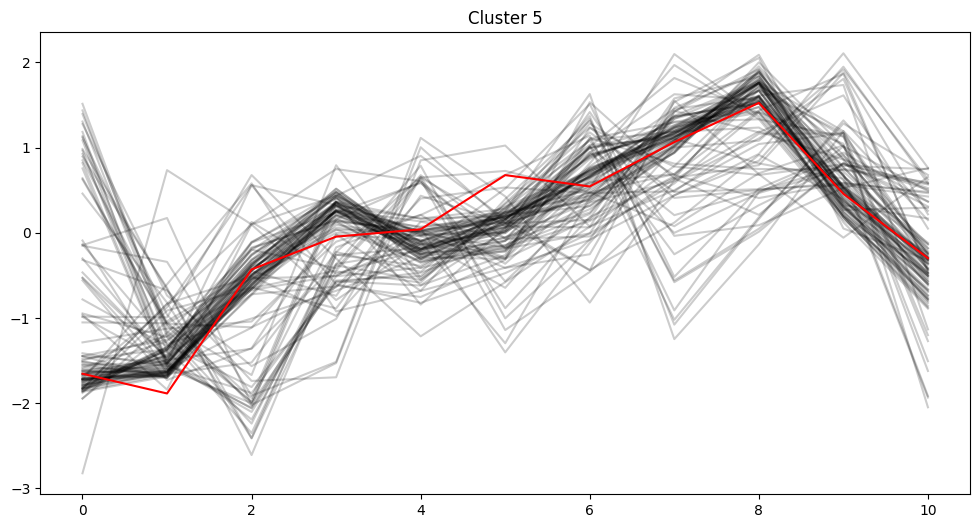

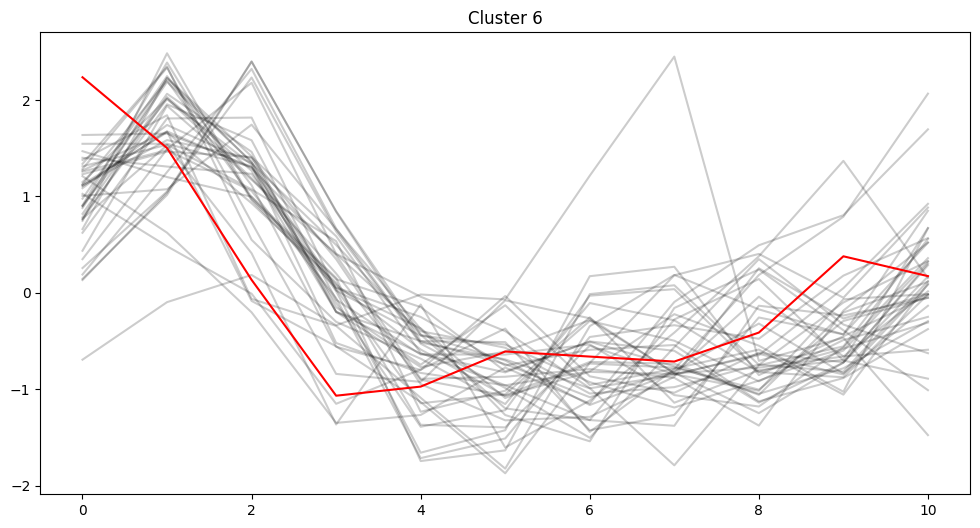

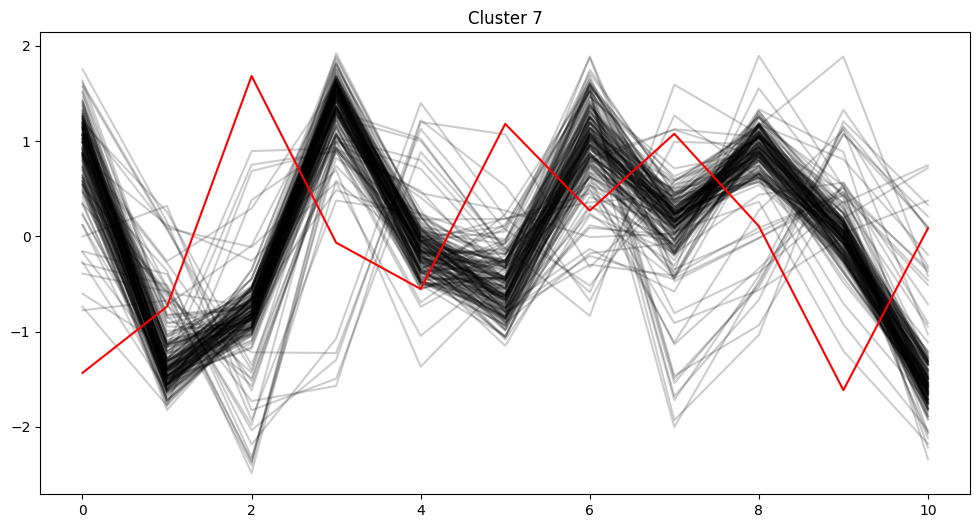

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### tslearn silhouette
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import KShape

n_clusters = 7

# Scale time series
scaler = TimeSeriesScalerMeanVariance(mu=0.0, std=1.0)
time_series_data_scaled = scaler.fit_transform(time_series_data)

# Perform time series clustering using k-Shape
kshape = KShape(n_clusters=n_clusters, n_init=10, verbose=True, random_state=42)
y_pred = kshape.fit_predict(time_series_data_scaled)

# Plot the time series and their cluster assignments
for yi in range(n_clusters):
    plt.figure(figsize=(12, 6))
    for xx in time_series_data_scaled[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=0.2)
    plt.plot(kshape.cluster_centers_[yi].ravel(), "r-")
    plt.title(f"Cluster {yi + 1}")

plt.show()


## Evaluate

In [82]:
from tslearn.metrics import cdist_dtw
from sklearn.metrics import silhouette_score



# Calculate the distance matrix using Dynamic Time Warping (DTW)
distance_matrix = cdist_dtw(time_series_data_scaled)

# Calculate the silhouette score
silhouette = silhouette_score(distance_matrix, y_pred, metric='precomputed')
print(f"Silhouette score: {silhouette}")

Silhouette score: 0.3109292916886873


## Statistical information

In [59]:
# Calculate statistical information for each cluster
for cluster in range(n_clusters):
    cluster_data = time_series_data[y_pred == cluster]

    # Calculate mean and variance
    cluster_mean = np.mean(cluster_data, axis=0)
    cluster_variance = np.var(cluster_data, axis=0)

    # Calculate autocorrelation
    cluster_data_df = pd.DataFrame(cluster_data)
    cluster_autocorr = cluster_data_df.apply(lambda x: x.autocorr(), axis=1).mean()

    print(f"Cluster {cluster + 1}:")
    print(f"Mean: {cluster_mean}")
    print(f"Variance: {cluster_variance}")
    print(f"Average Autocorrelation: {cluster_autocorr}")
    print("\n")

Cluster 1:
Mean: [0.83158875 0.80958212 0.74025343 0.76431705 0.78586359 0.73521255
 0.81196013 0.78767055 0.82351429 0.83434786 0.81854254 0.79874499]
Variance: [0.06653696 0.00632512 0.00492644 0.00636579 0.01392052 0.00324264
 0.02703508 0.0222995  0.00702164 0.0120896  0.01104777 0.01003269]
Average Autocorrelation: 0.08863556469073164


Cluster 2:
Mean: [0.76077856 0.80621506 0.79042688 0.74649319 0.70840291 0.7160604
 0.68669241 0.71794402 0.78066706 0.75068241 0.72405851 0.76700721]
Variance: [0.00197216 0.00112796 0.00201616 0.00272006 0.0059724  0.00213651
 0.00305724 0.00261305 0.00277328 0.00178633 0.00359954 0.00318243]
Average Autocorrelation: 0.1932585853149543


Cluster 3:
Mean: [0.58457232 0.92586611 1.06606066 0.2767868  0.80204272 1.15581615
 0.70444979 0.41332502 1.10299265 1.19938388 0.67916317 0.26937083]
Variance: [0.01881022 0.00286525 0.01671035 0.0114118  0.00674279 0.01188549
 0.00555528 0.01400981 0.00846149 0.00811787 0.00946094 0.00999862]
Average Autocorre

# Data

In [426]:
# Create a DataFrame to store the time series data and the cluster labels
result_df = pivot_df.copy()
result_df['Cluster'] = y_pred

# Calculate statistical information for each cluster and add to the result DataFrame
for cluster in range(n_clusters):
    cluster_data = time_series_data[y_pred == cluster]

    # Calculate mean and variance
    cluster_mean = np.mean(cluster_data, axis=0)
    cluster_variance = np.var(cluster_data, axis=0)

    # Calculate autocorrelation
    cluster_data_df = pd.DataFrame(cluster_data)
    cluster_autocorr = cluster_data_df.apply(lambda x: x.autocorr(), axis=1).mean()

    # Add statistical information to the result DataFrame
    result_df.loc[result_df['Cluster'] == cluster, 'Mean'] = cluster_mean.mean()
    result_df.loc[result_df['Cluster'] == cluster, 'Variance'] = cluster_variance.mean()
    result_df.loc[result_df['Cluster'] == cluster, 'Autocorrelation'] = cluster_autocorr

# Print the result
result_df.head()

date   2022-01-01/2022-02-01  2022-02-01/2022-03-01  2022-03-01/2022-04-01  \
field                                                                        
0                        0.0               0.841573               0.807760   
1                        0.0               0.846314               0.790300   
2                        0.0               0.863479               0.859740   
3                        0.0               0.895227               0.901925   
4                        0.0               0.908831               0.907711   

date   2022-04-01/2022-05-01  2022-05-01/2022-06-01  2022-06-01/2022-07-01  \
field                                                                        
0                   0.696798               0.883964               0.803519   
1                   0.612413               0.814059               0.849617   
2                   0.522208               0.851382               0.941563   
3                   0.431608               0.834731               0.971780   
4                   0.352323               0.823155               0.988167   

date   2022-07-01/2022-08-01  2022-08-01/2022-09-01  2022-09-01/2022-10-01  \
field                                                                        
0                   0.715134               0.668195               0.841399   
1                   0.695019               0.582343               0.921048   
2                   0.714716               0.501355               1.032338   
3                   0.668375               0.404303               1.065914   
4                   0.644748               0.312362               1.138900   

date   2022-10-01/2022-11-01  2022-11-01/2022-12-01  2022-12-01/2023-01-01  \
field                                                                        
0                   0.848658               0.722617               0.645882   
1                   0.960702               0.728509               0.576973   
2                   1.082728               0.702156               0.509662   
3                   1.119994               0.654099               0.428628   
4                   1.176872               0.589190               0.369074   

date   Cluster      Mean  Variance  Autocorrelation  
field                                                
0            6  0.802873  0.009982         0.272742  
1            6  0.802873  0.009982         0.272742  
2            6  0.802873  0.009982         0.272742  
3            4  0.795577  0.003708        -0.102790  
4            4  0.795577  0.003708        -0.102790

In [80]:
# Save to disk
result_df.to_csv('time_series_clustering.csv', index=False)